# GMM method analysis and final errors for DS-IC
- Images 400 to 599 in the database

In [ ]:
NOTEBOOK_CONFIG = {'IMG_LENGTH': 0.377,
                   'IMG_WIDTH': 0.143,
                   'IMG_XDIM': 143,
                   'IMG_YDIM': 377,
                   'labels_type' : "Labelsv0_detect",
                   'task' : "detect",
                   'model_name' : 'YOLOv0_E3_detect'}

In [ ]:
# Sample image
n_image = 401
image_path = f"../docs/Data/Images/gaussian_{n_image}.png"
label_path = f"../docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

In [15]:
from scipy.ndimage import laplace
import scipy.io

from skimage.feature import peak_local_max
from adjustText import adjust_text

In [17]:
from PIL import Image

# Load modules

In [20]:
import sys
sys.path.append("..")

In [21]:
from helpers.auxiliary_functions import (generate_grid,
                                         parameters_extract,
                                         checkpoint_error)
from helpers.aux_plotter import (plot_boxes_gmm,
                                 gaussians_labelled,
                                 plot_grayscale)
from helpers.gaussian_estimation import (sum_gaussians,
                                         compute_mse)

from pipelines.pipelines import (ppl_fit_gaussians,
                                 ppl_error_estimation)

    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result



# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [22]:
# Load 400 gaussians
mat = scipy.io.loadmat('../Data/db_80beam.mat')
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [23]:
# Generate GRID
x, y = generate_grid((0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                     (0, NOTEBOOK_CONFIG['IMG_LENGTH']), 
                     NOTEBOOK_CONFIG['IMG_XDIM'],
                     NOTEBOOK_CONFIG['IMG_YDIM'])

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Structure covariances
covariances = [np.diag(cov) for cov in zip((dispersion_x/np.sqrt(2))**2, 
                                           (dispersion_y/np.sqrt(2))**2)]

Number of indentifiable Gaussians (center in the image): 79


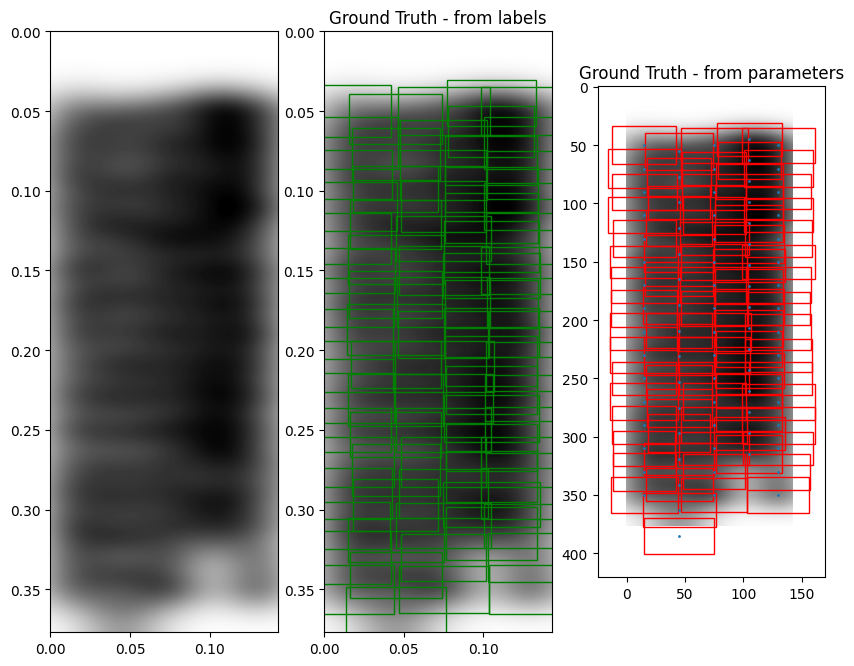

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means = list(zip(xs, ys)),
               covariances = covariances,
               ax = axs[2],
               beta = 3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s = 1)

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[2].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[2].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])
axs[2].invert_yaxis()

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

# [ESTIMATION PART III]
- Images: 400 - 599
  -  All amplitudes are higher around 2.1E6 (400%)
  - x center coincides with beta xs
  - y center Coincides with beta ys
  - dispersion in x Higher dispersion in x direction around 0.017 (170%)
  - dispersion in y Higher dispersion in y direction around 0.01 (170%)


## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [24]:
# Load data
# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

### Centers estimation

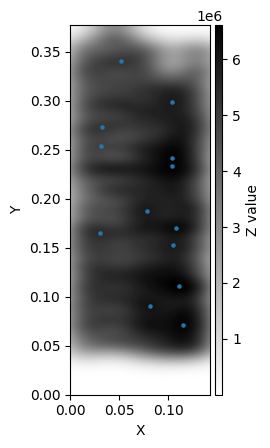

In [25]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

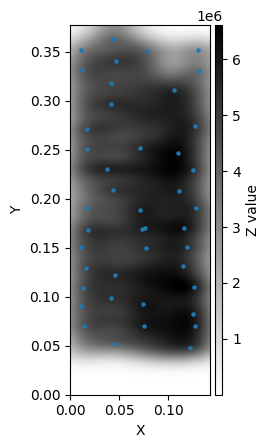

In [26]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s = 5)

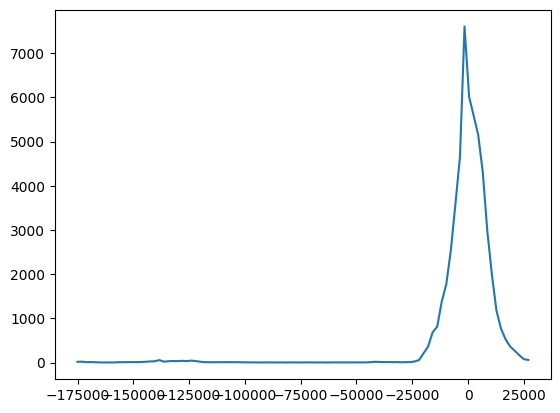

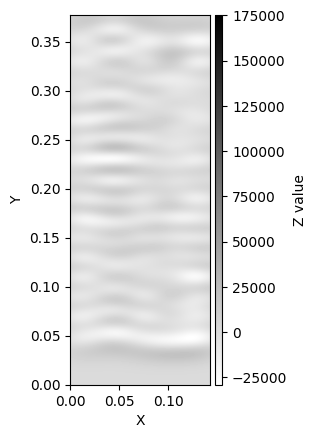

In [27]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins = 100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 11.190528154373169 seconds
ppl_fit_gaussians executed in 11.880757331848145 seconds


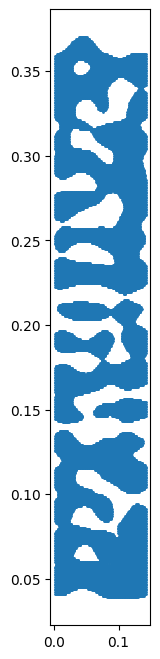

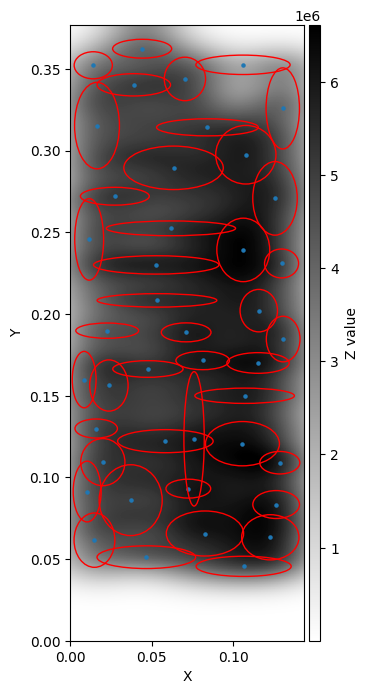

In [28]:
# Estimate Gaussian - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, NOTEBOOK_CONFIG['IMG_WIDTH']), 
                                                 (0, NOTEBOOK_CONFIG['IMG_LENGTH'])],
                                 image_size = [NOTEBOOK_CONFIG['IMG_XDIM'], 
                                               NOTEBOOK_CONFIG['IMG_YDIM']],
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

Number of indentifiable Gaussians (center in the image): 79


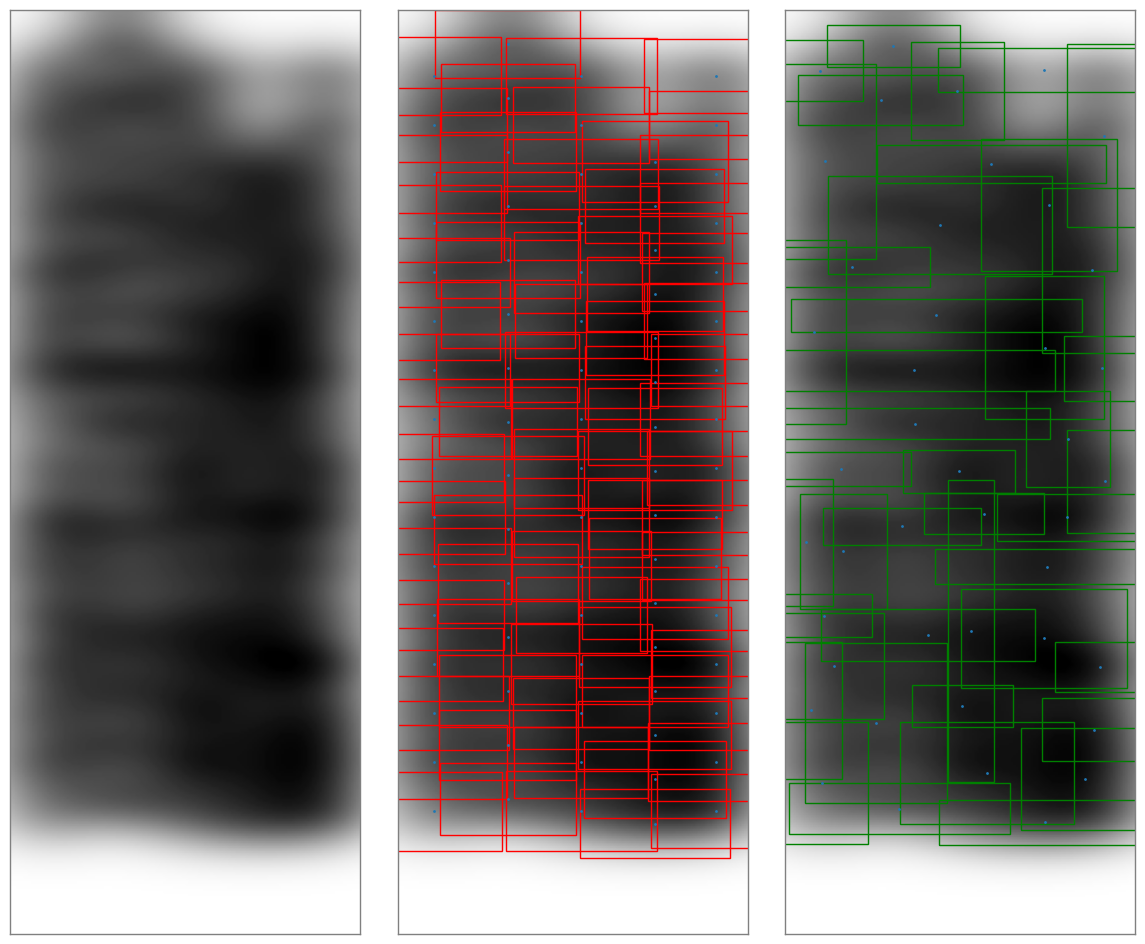

In [30]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means = means,
               covariances = covariances,
               ax = axs[2],
               beta = 3,
               edge_color = 'g')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0] * 1000, means[:, 1] * 1000, s = 1)
# axs[2].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG['IMG_XDIM'])
axs[2].set_ylim(0, NOTEBOOK_CONFIG['IMG_YDIM'])

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = NOTEBOOK_CONFIG['task'],
                   colorbar = False,
                   plot_centers = True)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[1].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG['IMG_WIDTH'])
axs[0].set_ylim(0, NOTEBOOK_CONFIG['IMG_LENGTH'])


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(f"../docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[533, 578, 591, 401, 513, 566, 451, 598, 518, 492, 501, 461, 473, 435, 414, 467, 491, 502, 454, 423]


In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - gmm' : [],
           'Number identifiable - gmm' : [],
           'Percentage - gmm' : [],
           'RMSE_cx - gmm' : [],
           'RMSE_cy - gmm' : [],
           'RMSE_c - gmm' : [],
           'RMSE_sigmax - gmm' : [],
           'RMSE_sigmay - gmm' : [],
           'RMSE_sigma - gmm' : [],
           'RMSE_amplitude - gmm': [],
           'MaxE_sigmax - gmm': [],
           'MaxE_sigmay - gmm': [],
           'MaxE_sigma - gmm': [],
           'RMSE_amplitude - gmm': [],
           'RMSEPixel - gmm': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       peak_method = 'laplace',
                                       estimation_method = "gmm",
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 4.818674564361572 seconds
ppl_fit_gaussians executed in 4.864920377731323 seconds
covariances [[[   0.034691           0]
  [          0   0.0069704]]]
covariances true [[[    0.02728           0]
  [          0    0.013755]]]
estimate_parameters_gmm executed in 5.201279878616333 seconds
ppl_fit_gaussians executed in 5.250646352767944 seconds
covariances [[[   0.025742           0]
  [          0   0.0062854]]]
covariances true [[[   0.026314           0]
  [          0    0.013085]]]
estimate_parameters_gmm executed in 3.896031618118286 seconds
ppl_fit_gaussians executed in 3.915583848953247 seconds
covariances [[[   0.038039           0]
  [          0   0.0071107]]]
covariances true [[[    0.02775           0]
  [          0    0.013163]]]
estimate_parameters_gmm executed in 4.187752962112427 seconds
ppl_fit_gaussians executed in 4.214830160140991 seconds
covariances [[[   0.029086           0]
  [          0   0.0061753]]]
covariances true [[[   

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

,mean,std,max
Image,493.10,58.18,598.00
Number identified - gmm,43.15,3.38,51.00
Number identifiable - gmm,79.00,0.00,79.00
Percentage - gmm,54.62,4.27,64.56
RMSE_cx - gmm,11.66,1.53,15.07
RMSE_cy - gmm,2.46,0.37,3.12
RMSE_c - gmm,11.93,1.52,15.38
RMSE_sigmax - gmm,36.22,2.42,41.42
RMSE_sigmay - gmm,44.07,4.15,55.55
RMSE_sigma - gmm,57.12,3.67,65.44


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,533,51,79,64.56,8.82,1.95,9.03,37.48,44.17,57.93,84.40,72.35,70.37,100.93,1090988.14
1,578,44,79,55.70,11.96,2.63,12.25,34.40,41.35,53.79,87.48,83.33,76.20,112.92,1144393.24
2,591,42,79,53.16,10.59,2.39,10.86,40.45,40.08,56.94,86.59,73.01,98.44,122.56,1109009.76
3,401,43,79,54.43,13.71,2.47,13.93,38.94,46.66,60.77,86.22,75.29,180.15,195.25,1061291.43
4,513,46,79,58.23,10.72,3.12,11.16,37.51,44.36,58.09,92.25,69.71,102.19,123.71,1066499.26
5,566,41,79,51.90,11.94,2.29,12.16,36.57,42.01,55.70,87.52,71.47,113.29,133.95,1135781.08
6,451,41,79,51.90,13.98,2.93,14.28,37.88,49.56,62.38,90.31,73.61,230.33,241.81,1169925.04
7,598,44,79,55.70,11.36,2.42,11.62,33.55,43.73,55.11,94.41,69.66,76.64,103.57,1093956.92
8,518,41,79,51.90,11.06,2.71,11.39,32.40,39.71,51.25,93.73,66.30,73.52,99.00,1194082.13
9,492,48,79,60.76,10.96,2.51,11.24,37.48,48.02,60.91,93.75,75.35,97.36,123.11,1167786.14


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""../docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {images_test}\n
                 id_estimation_method = {"GMM - random state 13 - first 200 images"}\n
                 id_images evaluated: {eval_images}""",
                 name = "E3GMM")

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)